---
title: "Advanced Optimization: Newton's Method and Adam"
author: Evan Flaks
date: '2025-04-22'
image: "newton.jpeg"
description: "Implementing and Comparing Advanced Optimization Methods for Logistic Regression"
format: html
---

In [219]:
import torch
import matplotlib.pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload 2
from newton import NewtonOptimizer, LogisticRegression, GradientDescentOptimizer, AdamOptimizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The source code for my implementation of Newton's method and Adam can be found in the [newton.py](https://github.com/evanflaks/evanflaks.github.io/blob/main/posts/newton/newton.py) python script.

# Abstract

This project explores advanced optimization methods for logistic regression, specifically comparing the performance of Newton’s method and the Adam optimizer. Newton’s method, a second-order technique, leverages curvature information from the Hessian matrix to achieve rapid convergence on convex loss functions. In contrast, Adam is a widely-used first-order optimizer in machine learning that relies on adaptive gradient estimates and is well-suited for large-scale or non-convex problems. The goal of this post is to empirically evaluate the efficiency of both methods in terms of convergence speed, measured by both clock time and iteration count. Using a binary classification dataset, we implement and test both optimizers, visualize their convergence behavior, and assess the efficiency of the optimizers

# Part A: Newton's Method

Newton’s ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍Method ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍is ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍a ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍*second-order* ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍optimization ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍technique. ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍This ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍means ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍that ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍it ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍requires ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍information ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍about ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍second ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍derivatives ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍of ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍loss ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍function ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍$L$
 ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍as ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍well ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍as ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍first ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍derivatives. ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍Here’s ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍how ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍Newton’s method works:
 
 1. We ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍compute ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍usual ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍gradient ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍$\nabla L(\mathbf{w})$. ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍Recall ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍that ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍gradient ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍is ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍vector ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍of ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍first ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍derivatives ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍of ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍$L$.
 2. We ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍also ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍compute ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍*‍Hessian ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍matrix*, ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍which ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍is ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍matrix ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍of ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍second ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍derivatives ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍of ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍$L$. ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍For ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍logistic ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍regression, ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍Hessian ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍is ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍matrix ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍$‍\mathbf{H}(\mathbf{w}) \in \mathbb{R}^{p \times p}$
 ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍with ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍entries 
 $$\begin{aligned}
h_{ij}(\mathbf{w}) = \sum_{k = 1}^n x_{ki}x_{kj}\sigma(s_k)(1-\sigma(s_k))\;.
\end{aligned}
\tag{1}$$‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍
Once ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍we ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍know ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍how ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍to ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍calculate ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍gradient ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍and ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍Hessian, ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍we ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍repeat ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍update ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍

\begin{aligned}
    w \gets w - \alpha \mathbf{H}(\mathbf{w})^{-1} \nabla L (\mathbf{w})\;.
\end{aligned}

‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍until ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍convergence. Here, $\alpha >0$ is a learning rate and $\mathbf{H}(\mathbf{w})^{-1}$ is ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍matrix ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍inverse ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍of ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍Hessian ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍matrix.



## Implementing Newton's Method for Logistic Regression

My implementation of Newton's method can be found in the <code>NewtonOptimizer</code> class of my ([newton.py](https://github.com/evanflaks/evanflaks.github.io/blob/main/posts/newton/newton.py)) script. The class implements a second-order optimization algorithm for training logistic regression models using Newton's Method. Unlike gradient descent, which updates weights using only the gradient of the loss function, Newton's Method incorporates both the gradient and the curvature (second derivatives) by computing the Hessian matrix of the loss. In the  <code>step()</code> function, the optimizer first calculates the gradient and Hessian of the logistic loss based on the current model weights. To ensure numerical stability, a small value ($\epsilon = 1e-5$) is added to the diagonal of the Hessian matrix before inverting it. The optimizer then computes the update direction by solving the linear system $H^{-1}\nabla L$, and applies this step, scaled by a learning rate $\alpha$, to update the model's weight vector.

## Testing my Newton's Method Implementation

In order to test my implementation, below I generated a synthetic binary classification dataset. The code then trains a logistic regression model using both Gradient Descent and Newton’s Method, and compares their final weights and losses. Finally, the script prints the learned weights and logistic loss for both optimization methods, allowing for direct comparison of their effectiveness and efficiency.

In [220]:
import torch
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler

# Create synthetic data
X_np, y_np = make_classification(n_samples=200, n_features=5, n_informative=5, 
                                 n_redundant=0, random_state=42)

# Add bias term (column of 1s)
X_np = StandardScaler().fit_transform(X_np)
X_np = torch.tensor(X_np, dtype=torch.float32)
X = torch.cat([X_np, torch.ones((X_np.shape[0], 1))], dim=1)  # (n, p+1)
y = torch.tensor(y_np, dtype=torch.float32)

# Create and train with gradient descent
model_gd = LogisticRegression()
gd_optimizer = GradientDescentOptimizer(model_gd)

for _ in range(1000):  # enough iterations for convergence
    gd_optimizer.step(X, y, alpha=0.1, beta=0.0)

# Create and train with Newton's method ----
model_newton = LogisticRegression()
model_newton.w = model_gd.w.clone().detach()  # start from same weights
newton_optimizer = NewtonOptimizer(model_newton)

for _ in range(10):  # Newton usually converges quickly
    newton_optimizer.step(X, y, alpha=0.1)

# ---- 4. Compare Results ----
print("\n--- Weights ---")
print("Gradient Descent Weight:", model_gd.w)
print("Newton's Method Weight:",model_newton.w)

print("\n--- Losses ---")
print("Gradient Descent Loss:", model_gd.loss(X, y).item())
print("Newton Method Loss:   ", model_newton.loss(X, y).item())



--- Weights ---
Gradient Descent Weight: tensor([ 0.5396, -0.7425, -0.5691, -0.2343,  0.2292, -0.0523])
Newton's Method Weight: tensor([ 0.5396, -0.7425, -0.5692, -0.2343,  0.2292, -0.0523])

--- Losses ---
Gradient Descent Loss: 0.5675735473632812
Newton Method Loss:    0.567573606967926


As we can see, our Newton's method implementation achieved the same loss value and weight vector as the gradient descent, veryifying that our implemendation works correctly.  

## Newton's Method Experiments

For our experiments we are going to be working with this [mushroom dataset](https://archive.ics.uci.edu/dataset/73/mushroom) that includes descriptions of samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family. With our model, we will classify each mushroom as either poisonous or edible. This data set was found on the UC Irvine Machine Learning Repository and the data was donated by the Audobon Society Field Guide.

We being by loading the data and reading it into a data frame.

In [221]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import torch

# Load the dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data'
column_names = [
    'class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
    'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
    'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
    'stalk-surface-below-ring', 'stalk-color-above-ring',
    'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
    'ring-type', 'spore-print-color', 'population', 'habitat'
]
df = pd.read_csv(url, header=None, names=column_names)

df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


Now I must prepare the dataset for training using PyTorch. The code below first cleans the data by replacing missing values and dropping any rows that contain missing values. Then, it separates the features (X) from the target (y), mapping edible mushrooms to 0 and poisonous ones to 1. Since the features are categorical, they are transformed into a numerical format using one-hot encoding. A bias term (a column of ones) is added to the features. The processed data is then converted into PyTorch tensors, and finally, the dataset is split into training and testing sets using an 80-20 split.

In [222]:
# Drop rows with missing values
df = df.replace('?', pd.NA).dropna()

# Separate features and target
X = df.drop('class', axis=1)
y = df['class'].map({'e': 0, 'p': 1})  # edible=0, poisonous=1

# One-hot encode categorical features
encoder = OneHotEncoder(sparse=False)
X_encoded = encoder.fit_transform(X)

# Add bias term (column of ones)
X_encoded = np.hstack([X_encoded, np.ones((X_encoded.shape[0], 1))])

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_encoded, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_tensor, y_tensor, test_size=0.2, random_state=42
)

### Experiment 1: Convergence to Weight Vector

For our first experiment, we want to show that when ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍$\alpha$ is ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍chosen ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍appropriately, ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍Newton’s ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍method ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍converges ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍to ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍correct ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍choice ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍of ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍$\mathbf{w}$.

The code below first trains a model using Gradient Descent for 300 iterations with a learning rate of 0.05 and no momentum, recording the training loss after each update. Next, it trains a separate model from scratch using Newton’s Method with a learning rate of 1.0 for 50 iterations, and tracks the corresponding loss values. Finally, the code generates a plot showing the training loss curves for both methods, visually illustrating their convergence behavior.

Final Gradient Descent loss: 0.131521
Final Newton loss (α=1): 0.049707


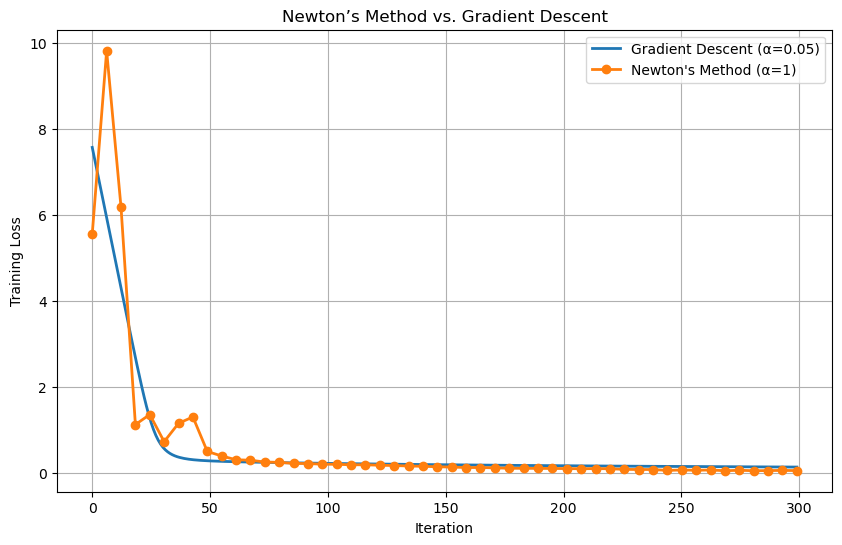

In [223]:
# --------- Train Gradient Descent baseline ---------
model_gd = LogisticRegression()
gd_optimizer = GradientDescentOptimizer(model_gd)
gd_losses = []

for _ in range(300):
    gd_optimizer.step(X_train, y_train, alpha=0.05, beta=0.0)
    gd_losses.append(model_gd.loss(X_train, y_train).item())

print(f"Final Gradient Descent loss: {gd_losses[-1]:.6f}")

# --------- Newton’s Method (alpha = 1) ---------
model_newton = LogisticRegression()
_ = model_newton.score(X_train)  # trigger random weight initialization
newton_optimizer = NewtonOptimizer(model_newton)
newton_losses = []

for _ in range(50):
    newton_optimizer.step(X_train, y_train, alpha=1.0)
    newton_losses.append(model_newton.loss(X_train, y_train).item())

print(f"Final Newton loss (α=1): {newton_losses[-1]:.6f}")

# --------- Visualize ---------
plt.figure(figsize=(10, 6))
plt.plot(gd_losses, label='Gradient Descent (α=0.05)', linewidth=2)
plt.plot(np.linspace(0, len(gd_losses)-1, len(newton_losses)), newton_losses, 
         label="Newton's Method (α=1)", marker='o', linewidth=2)
plt.xlabel("Iteration")
plt.ylabel("Training Loss")
plt.title("Newton’s Method vs. Gradient Descent")
plt.legend()
plt.grid(True)
plt.show()


As we can see by the overlapping organge and blue curves, when the learning rate $\alpha$ is chosen appropriately, Newton’s Method successfully converges to the correct set of weights $\mathbf{w}$ that minimize the logistic loss function.

### Experiment 2: Newton's Method vs. Standard Gradient Descent

For our second experiment, we want to demonstrate that, under at least ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍some ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍circumstances, ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍Newton’s ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍method ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍can ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍converge ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍much ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍faster ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍than ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍standard ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍gradient ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍descent that I ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍implemented ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍in my ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍previous ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍blog ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍post ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍on ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍logistic ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍regression, ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍in ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍sense ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍of ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍decreasing ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍empirical ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍risk.

The code below initializes two identical models with the same starting weights to ensure a fair comparison. It then runs both optimizers for 100 iterations, recording the logistic loss at each step. The Gradient Descent optimizer and the Newton Method optimizer both use a learning rate of 0.01. After training, the code plots both loss curves on the same graph.

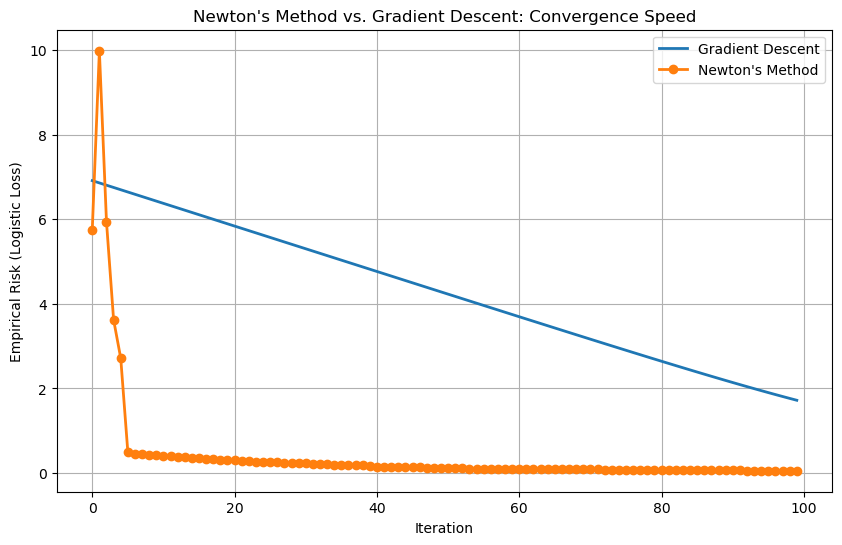

In [224]:
import matplotlib.pyplot as plt

# Re-initialize models to start from same point
model_gd = LogisticRegression()
model_newton = LogisticRegression()
_ = model_gd.score(X_train)           # Triggers weight init
model_newton.w = model_gd.w.clone()   # Start at same weights

# Set up optimizers
gd_optimizer = GradientDescentOptimizer(model_gd)
newton_optimizer = NewtonOptimizer(model_newton)

# Track losses
gd_losses = []
newton_losses = []

# Run for 30 iterations each (Newton usually converges much faster)
num_iterations = 100

for i in range(num_iterations):
    gd_optimizer.step(X_train, y_train, alpha=0.01, beta=0.0)
    newton_optimizer.step(X_train, y_train, alpha=0.01)

    gd_losses.append(model_gd.loss(X_train, y_train).item())
    newton_losses.append(model_newton.loss(X_train, y_train).item())

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(gd_losses, label="Gradient Descent", linewidth=2)
plt.plot(newton_losses, label="Newton's Method", marker='o', linewidth=2)
plt.xlabel("Iteration")
plt.ylabel("Empirical Risk (Logistic Loss)")
plt.title("Newton's Method vs. Gradient Descent: Convergence Speed")
plt.legend()
plt.grid(True)
plt.show()


As we can see from these loss curves, when $\alpha = 0.01$, the empirical risk for Newton's method converged *much* faster than that of the standard gradient descent. 

### Experiment 3: Failed Convergence

For this experiment, we want to demonstrate that when $\alpha$ is too large, Newton's method fails to converge as all.

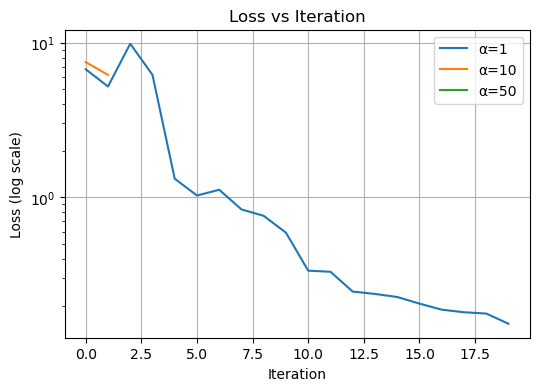

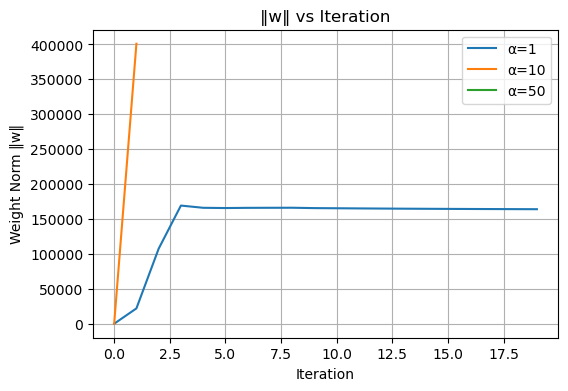

In [234]:
import torch
import matplotlib.pyplot as plt

alphas = [1, 10, 50]
max_iters = 20

loss_hist = {}
norm_hist = {}

for alpha in alphas:
    model = LogisticRegression()
    _ = model.score(X_train)        # init w
    opt = NewtonOptimizer(model)

    losses, norms = [], []
    for _ in range(max_iters):
        L = model.loss(X_train, y_train).item()
        losses.append(L)
        norms.append(model.w.norm().item())

        # step
        opt.step(X_train, y_train, alpha=alpha)

        # stop early if w becomes NaN or absurdly large
        if torch.isnan(model.w).any() or model.w.norm().item() > 1e6:
            break

    loss_hist[alpha] = losses
    norm_hist[alpha] = norms

# 1) Loss vs iters (you’ll see it still goes to zero)
plt.figure(figsize=(6,4))
for α, hist in loss_hist.items():
    plt.semilogy(hist, label=f'α={α}')
plt.title('Loss vs Iteration')
plt.xlabel('Iteration')
plt.ylabel('Loss (log scale)')
plt.legend()
plt.grid(True)

# 2) Weight‐norm vs iters (this will blow up for large α!)
plt.figure(figsize=(6,4))
for α, hist in norm_hist.items():
    plt.plot(hist, label=f'α={α}')
plt.title('‖w‖ vs Iteration')
plt.xlabel('Iteration')
plt.ylabel('Weight Norm ‖w‖')
plt.legend()
plt.grid(True)
plt.show()


In the Loss vs. Iteration chart, the blue curve for $\alpha=1$ steadily drives the logistic loss toward zero over many iterations, showing proper convergence. By contrast, the orange curve for $\alpha=10$ (and the barely visible green curve for $\alpha=50$) spikes upward almost immediately and then disappears—Newton’s updates are so large that the model “jumps” out of the basin of attraction instead of descending, so loss never decreases. The $‖w‖$ vs. Iteration plot confirms this: for $\alpha=1$ the weight norm grows smoothly to a plateau, but for $\alpha=10$ the norm explodes into the hundreds of thousands in a single step (and similarly for $\alpha=50$), signaling runaway parameters. Together, these visualizations show that once the step size $\alpha$ exceeds a critical threshold, Newton’s method no longer converges at all but instead diverges catastrophically.

# Part B: Adam

The ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍Adam ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍optimization ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍algorithm ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍is ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍a ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍mainstay ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍of ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍modern ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍deep ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍learning. ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍Unlike ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍Newton’s ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍method, ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍which ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍is ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍usually ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍applied ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍to ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍entire ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍data ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍set ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍at ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍once, ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍Adam ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍is ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍a ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍variation ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍on ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍stochastic ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍gradient ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍descent. ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍Adam ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍was ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍introduced ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍by ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍Kingma and Ba ([2015](https://arxiv.org/abs/1412.6980)).

Adam (Adaptive Moment Estimation) is a widely used optimization algorithm in machine learning. Like Newton’s method, Adam attempts to optimize a loss function $L(\theta)$, but it does so using first-order information only—meaning it uses gradients but not second derivatives. What makes Adam powerful is its use of adaptive learning rates, informed by estimates of both the first moment (mean) and the second moment (uncentered variance) of the gradients.

Here’s how Adam works:

1. We begin by computing the gradient of the stochastic objective function at step $t$:
$$g_t = \nabla_{\theta}f_t(\theta_{t-1})$$
This is analogous to the $L(\theta)$ term in Newton’s method and gives the direction of steepest descent for the current mini-batch.

2. Next, we compute exponentially decaying averages of past gradients and squared gradients. These are the first moment $m_t$ and second moment $v_t$, initialized as vectors of zeros: 
$$m_t = \beta_1 \cdot m_{t-1} +(1-\beta_1)\cdot g_t$$
$$v_t = \beta_2 \cdot v_{t-1} +(1-\beta_2)\cdot g_t^2$$
Here, $\beta_1 \in [0,1)$ controls the decay rate of the moving average of the gradient (like momentum), while $\beta_2 \in [0,1)$ does the same for the squared gradient.

3. Because both $m_t$ and $v_t$ are initialized at 0, they are biased towards zero. To counteract this, Adam computers bias-corrected estimates

$$\hat{m}_t = \frac{m_t}{1-\beta_{1}^t}$$
$$\hat{v}_t = \frac{v_t}{1-\beta_{2}^t}$$

4. Finally, we update the paramters using the following rule:

$$\theta_t = \theta_{t-1} - \alpha \cdot \frac{\hat{m}_t}{\sqrt{\hat{v}}+\epsilon}$$

Here, $\alpha$ is the step size (learning rate), and $\epsilon$ is a small constant added for numerical stability to avoid division by zero. This update rule allows element-wise adaptive learning rates, which makes Adam particularly effective for problems with sparse or noisy gradients.

Adam repeats this update rule until convergence is achieved. 

## Implementing Adam for Logistic Regression

My implementation of Adam can be found in the <code>AdamOptimizer</code> class of my ([newton.py](https://github.com/evanflaks/evanflaks.github.io/blob/main/posts/newton/newton.py)) script. The class maintains two exponentially decaying averages: the first moment (<code>m</code>) estimates the mean of the gradients, and the second moment (<code>v</code>) estimates the uncentered variance. These are corrected for bias to stabilize updates during the early iterations. In each step, the optimizer shuffles the dataset, splits it into batches, and performs a parameter update for each batch using the Adam formula. The update rule adjusts the learning rate for each parameter individually, making training more stable and efficient—especially in settings with noisy or sparse gradients. The class accepts user-defined values for batch size, learning rate (alpha), moment decay rates (<code>beta1</code>, <code>beta2</code>), and an optional initial weight vector (<code>w_0</code>). If <code>w_0</code> is not provided, the optimizer initializes the weights on the first call.

## Testing My Adam Implementation

Now we want to test our implementation of Adam by seeing if it can achieve the same weights and loss as gradient descent. In the code below, I generated a synthetic binary classification dataset. The code then trains a logistic regression model using both Gradient Descent and Adam, and compares their final weights and losses. Finally, the script prints the learned weights and logistic loss for both optimization methods, allowing for direct comparison of their effectiveness and efficiency.

In [225]:

# Step 1: Generate synthetic dataset
X_np, y_np = make_classification(n_samples=200, n_features=5, n_informative=5,
                                 n_redundant=0, random_state=42)

X_np = StandardScaler().fit_transform(X_np)
X_np = torch.tensor(X_np, dtype=torch.float32)
X = torch.cat([X_np, torch.ones((X_np.shape[0], 1))], dim=1)
y = torch.tensor(y_np, dtype=torch.float32)

# Step 2: Train with Gradient Descent
model_gd = LogisticRegression()
gd_optimizer = GradientDescentOptimizer(model_gd)
for _ in range(1000):
    gd_optimizer.step(X, y, alpha=0.1, beta=0.0)

# Step 3: Train with Adam
model_adam = LogisticRegression()
adam_optimizer = AdamOptimizer(model_adam, batch_size=32, alpha=0.01)
for _ in range(100):
    adam_optimizer.step(X, y)

# Step 4: Print and Compare Results
print("\n--- Weights ---")
print("Gradient Descent Weight:", model_gd.w)
print("Adam Weight:             ", model_adam.w)

print("\n--- Losses ---")
print("Gradient Descent Loss:", model_gd.loss(X, y).item())
print("Adam Loss:             ", model_adam.loss(X, y).item())



--- Weights ---
Gradient Descent Weight: tensor([ 0.5396, -0.7425, -0.5691, -0.2342,  0.2292, -0.0523])
Adam Weight:              tensor([ 0.5203, -0.7613, -0.5800, -0.2638,  0.2062, -0.0350])

--- Losses ---
Gradient Descent Loss: 0.567573606967926
Adam Loss:              0.5677948594093323


As we can see, our implementation of Adam achieved nearly identical loss value as the gradient descent, and a near identical weight vector on the synthetic dataset, veryifying that our implemendation works correctly.  

# Part C: Newton's Method vs. Adam

Working with the same mushroom classification dataset as before, we are now going to compare the speed of convergence for Newton's method and Adam.

Newton converged in 68 iterations, taking 0.0377 seconds.
Adam converged in 8 iterations, taking 0.0526 seconds.


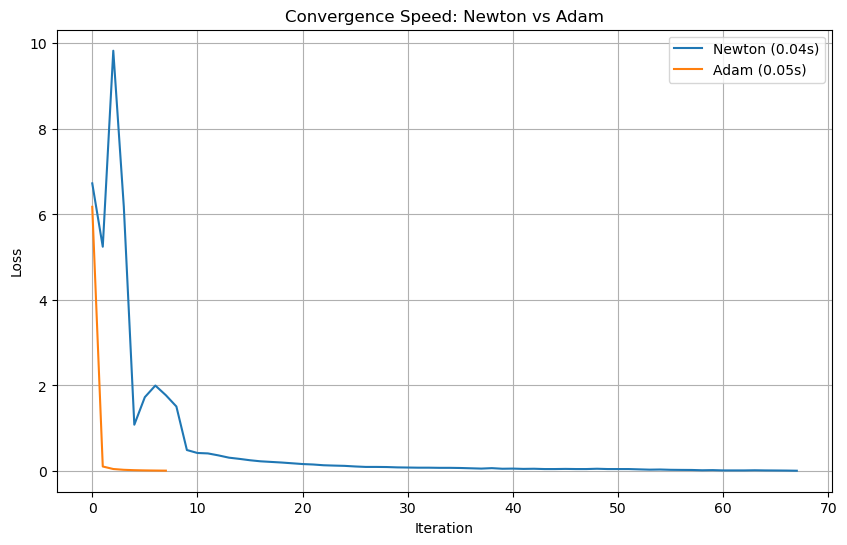

In [227]:
import torch
import matplotlib.pyplot as plt
import time
import numpy as np

target_loss = 0.01
max_iters = 100
results = {}

def run_experiment(name, optimizer_class, model_class, **kwargs):
    model = model_class()
    optimizer = optimizer_class(model, **kwargs)
    start_time = time.time()
    losses = []

    for _ in range(max_iters):
        loss = model.loss(X_train, y_train).item()
        losses.append(loss)
        if loss <= target_loss:
            break
        optimizer.step(X_train, y_train)
    
    duration = time.time() - start_time
    results[name] = {
        'losses': losses,
        'time': duration,
        'iterations': len(losses)
    }

# Run experiments
run_experiment("Newton", NewtonOptimizer, LogisticRegression)
run_experiment("Adam", AdamOptimizer, LogisticRegression, alpha=0.01, batch_size=32)

# Print timing results
for name, data in results.items():
    print(f"{name} converged in {data['iterations']} iterations, taking {data['time']:.4f} seconds.")

# Plotting loss per iteration
plt.figure(figsize=(10, 6))
for name, data in results.items():
    plt.plot(data['losses'], label=f"{name} ({data['time']:.2f}s)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Convergence Speed: Newton vs Adam")
plt.legend()
plt.grid(True)
plt.show()

From our results, we can see that on our Mushroom classification dataset, Adam converged to our target loss value of 0.01 in only 8 iterations compared to Newton's method which took 68 iterations. However, when we look at elapsed time in seconds, Newton's method converged in 0.0377 seconds compared to Adam, which converged to our target loss in 0.0526 seconds. This means, although Adam may use fewer iterations to reach a target loss, for this experiment, Newton's method was faster.

# Concluding Discussion

Through this project, I successfully implemented and rigorously tested two advanced optimization algorithms—Newton’s Method and Adam—for logistic regression. I gained hands-on experience with second-order methods and deepened my understanding of how curvature information (via the Hessian) influences convergence. By comparing these techniques on both synthetic and real-world data, I learned that while Adam often converges in fewer iterations due to its adaptive learning rates, Newton’s method can be significantly faster in terms of wall-clock time when the dimensionality and data size are manageable. This tradeoff between iteration count and computational cost per iteration is a key takeaway when choosing an optimizer for a specific task. Additionally, experimenting with different learning rates and observing divergent behavior helped me appreciate the sensitivity of Newton’s method to hyperparameters. Overall, this project not only solidified my technical skills in PyTorch and numerical optimization but also taught me how to empirically evaluate algorithm performance in a meaningful, reproducible way.